In [1]:
from glob import glob
from astroquery.mast import Mast, Observations
import os
import shutil
import numpy as np
import json
import requests
import asdf
import regions
from astropy import log
from astropy.io import ascii, fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.utils.data import download_file
from astropy.visualization import ImageNormalize, ManualInterval, LogStretch, LinearStretch
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table
from astropy.nddata import Cutout2D
import astropy.units as u
import stdatamodels


# do this before importing webb
os.environ["CRDS_PATH"] = "/orange/adamginsburg/jwst/brick/crds/"
os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"

from jwst.pipeline import calwebb_image3
from jwst.pipeline import Detector1Pipeline, Image2Pipeline

# Individual steps that make up calwebb_image3
from jwst.tweakreg import TweakRegStep
from jwst.tweakreg.utils import adjust_wcs
from jwst.skymatch import SkyMatchStep
from jwst.outlier_detection import OutlierDetectionStep
from jwst.resample import ResampleStep
from jwst.source_catalog import SourceCatalogStep
from jwst import datamodels
from jwst.associations import asn_from_list
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base
from jwst.datamodels import DataModel
from jwst.datamodels import ImageModel

import jwst.datamodels
from jwst import datamodels

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
filtername = "F182M"
#basepath = '/orange/adamginsburg/jwst/cloudc/'
basepath = '/orange/adamginsburg/jwst/brick/'

In [7]:
#reg_off = regions.Regions.read('/orange/adamginsburg/jwst/cloudc/regions_/offset_1.reg')[0]

In [8]:
files = glob(f"{basepath}/{filtername}/pipeline/*nrc*_cal.fits")
files

['/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00016_nrcb1_cal.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00019_nrcb2_cal.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00007_nrca1_cal.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00015_nrcb1_cal.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00009_nrcb4_cal.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00023_nrca1_cal.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00021_nrca1_cal.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00012_nrcb4_cal.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00003_nrca3_cal.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00015_nrca2_cal.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_

In [73]:
ls /orange/adamginsburg/jwst/cloudc/images/*f405n*

/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f405n-merged-nodestreak_i2d-perfilt64.fits
/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f405n-merged-nodestreak_i2d.fits
/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f405n-merged-nodestreak_i2d_chunk-medfilt128.fits
/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f405n-merged-nodestreak_i2d_medfilt128.fits
/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f405n-merged_i2d.fits


In [57]:
#tbl = Table.read(f'{basepath}/catalogs/crowdsource_based_nircam-f405n_reference_astrometric_catalog.ecsv')
#tbl = Table.read(f'{basepath}/catalogs/crowdsource_based_nircam-f405n_reference_astrometric_catalog.ecsv')
tbl = Table.read('/orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-merged-reproject_vvvcat.ecsv')
crds = tbl['skycoord']

KeyError: 'skycoord'

In [10]:
filename = files[0]
#'/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f405n-merged_i2d.fits'
#files[0]

In [11]:
from astropy import units as u
from astropy.io import ascii, fits
import numpy as np
pixel_scale = np.sqrt(fits.getheader(filename, ext=1)['PIXAR_A2']*u.arcsec**2)/u.pix
pixel_scale

<Quantity 0.03074648 arcsec / pix>

In [14]:
files_overlap = []

for fn in files:
    hdu = fits.open(fn)['SCI']
    size = (2*u.arcsec/pixel_scale, 2*u.arcsec/pixel_scale)
    reg_off_pix = reg_off.to_pixel(wcs=WCS(hdu.header))
    mask = reg_off_pix.to_mask()
    data = mask.cutout(hdu.data)
    weighted_data = mask.multiply(hdu.data)
    if weighted_data is not None:
        print(fn)
        files_overlap.append(fn)

/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_02201_00003_nrca3_align.fits
/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_08201_00003_nrcb4_align.fits
/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002002_02201_00004_nrcb2_align.fits
/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_08201_00002_nrcb4_align.fits
/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002002_02201_00002_nrcb2_align.fits
/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_08201_00004_nrcb4_align.fits
/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002002_02201_00001_nrcb2_align.fits
/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002002_02201_00003_nrcb2_align.fits
/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_02201_00002_nrca3_align.fits
/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_08201_00001_nrcb4_align.fits
/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_02201_00004_nrca3_align.fits

# Align A and B

In [77]:
#fna = '/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_02201_00001_nrca1_destreak_tweakregstep.fits'
#fnb = '/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002002_08201_00001_nrcb4_destreak_tweakregstep.fits'
#fna = '/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_02201_00001_nrca1_align.fits'
#fnb = '/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002002_08201_00001_nrcb4_align.fits'
#fna = '/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002002_04201_00003_nrca3_align.fits'
#fnb = '/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002002_10201_00003_nrcb4_align.fits'
#fna = '/orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00002_nrca1_align.fits'
#fnb = '/orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_12201_00003_nrcb4_align.fits'
fna = '/orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00003_nrca1_destreak.fits'
fnb = '/orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_12201_00003_nrcb4_destreak.fits'
#fna = '/orange/adamginsburg/jwst/cloudc//F405N/pipeline/jw02221002002_08201_00001_nrcalong_cal.fits'
#fnb = '/orange/adamginsburg/jwst/cloudc//F405N/pipeline/jw02221002002_02201_00003_nrcblong_cal.fits'

ima = ImageModel(fna)
imb = ImageModel(fnb)

hdu_a = fits.open(fna)#ImageModel(filename)
ww_a = WCS(hdu_a['SCI'].header)

hdu_b = fits.open(fnb)#ImageModel(filename)
ww_b = WCS(hdu_b['SCI'].header)

reg_frame = regions.RectangleSkyRegion(center=ima.meta.wcs.pixel_to_world(hdu_a['SCI'].header['CRPIX1'], hdu_a['SCI'].header['CRPIX2']), width=2048*u.pix*pixel_scale, height=2048*u.pix*pixel_scale)
crds_frame = crds[reg_frame.contains(crds, wcs=ww_a)]

reg_b = regions.RectangleSkyRegion(center=imb.meta.wcs.pixel_to_world(hdu_b['SCI'].header['CRPIX1'], hdu_b['SCI'].header['CRPIX2']), width=2048*u.pix*pixel_scale, height=2048*u.pix*pixel_scale)
crds_ab = crds_frame[reg_b.contains(crds_frame, wcs=ww_b)]

In [78]:
position = crds_ab[np.random.randint(len(crds_ab)-1)]
position

<SkyCoord (ICRS): (ra, dec) in deg
    (266.59358276, -28.57716589)>

In [79]:
# jw02221002001_08201_00002_nrca3_cal.fits
# jw02221002002_08201_00003_nrcb4_cal.fits

size = (3*u.arcsec/pixel_scale, 3*u.arcsec/pixel_scale)#im.meta.wcs.world_to_pixel(1*u.arcsec, 1*u.arcsec)

ima = ImageModel(fna)
imb = ImageModel(fnb)

hdu_1 = fits.open(fna)
hdu_2 = fits.open(fnb)

ww_1 = WCS(hdu_1['SCI'].header)
ww_2 = WCS(hdu_2['SCI'].header)

minn = 5
maxx = 90

cutout_1 = Cutout2D(hdu_1['SCI'].data, position=position, size=size, wcs=ww_1)
cutout_2 = Cutout2D(hdu_2['SCI'].data, position=position, size=size, wcs=ww_2)

ax_1 = plt.subplot(121, projection=cutout_1.wcs)
ax_2 = plt.subplot(122, projection=cutout_2.wcs)

vmin = 0 #np.nanpercentile(cutout_1.data.flatten(), minn)
vmax = 50 #np.nanpercentile(cutout_1.data.flatten(), maxx)
ax_1.imshow(np.nan_to_num(cutout_1.data), vmin=vmin, vmax=vmax)
vmin = 0 #np.nanpercentile(cutout_2.data.flatten(), minn)
vmax = 50 #np.nanpercentile(cutout_2.data.flatten(), maxx)
ax_2.imshow(np.nan_to_num(cutout_2.data), vmin=vmin, vmax=vmax)

reg = regions.RectangleSkyRegion(center=position, width=size[1]*pixel_scale, height=size[0]*pixel_scale)
crds_in = crds_ab[reg.contains(crds_ab, wcs=ww_1)]

#NRCA
ra_shift_1 =  0*u.arcsec#-0.05*u.arcsec#0.15*u.arcsec#-0.25*u.arcsec
dec_shift_1 = 0*u.arcsec#-0.11*u.arcsec#0.15*u.arcsec#0.05*u.arcsec
#NRCB 
ra_shift_2 =  0*u.arcsec#0.18*u.arcsec#0.0*u.arcsec
dec_shift_2 = 0*u.arcsec#-0.25*u.arcsec#0.05*u.arcsec#-0.05*u.arcsec

ax_1.scatter(crds_in.ra+ra_shift_1, crds_in.dec+dec_shift_1, edgecolor='r', facecolor='none', transform=ax_1.get_transform('world'))
ax_2.scatter(crds_in.ra+ra_shift_2, crds_in.dec+dec_shift_2, edgecolor='r', facecolor='none', transform=ax_2.get_transform('world'))

ax_1.scatter(position.ra, position.dec, edgecolor='white', facecolor='none', s=50, marker='*', transform=ax_1.get_transform('world'))
ax_2.scatter(position.ra, position.dec, edgecolor='white', facecolor='none', s=50, marker='*', transform=ax_2.get_transform('world'))

ax_1.set_title('NRCA')
ax_2.set_title('NRCB')

ax_1.set_axis_off()
ax_2.set_axis_off()

plt.tight_layout()
plt.show()

# Single Image Alignment

In [49]:
files = glob(f"{basepath}/{filtername}/pipeline/*0000*_nrcb3_cal.fits")
files

['/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00005_nrcb3_cal.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00008_nrcb3_cal.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00006_nrcb3_cal.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00003_nrcb3_cal.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00002_nrcb3_cal.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00007_nrcb3_cal.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00004_nrcb3_cal.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00009_nrcb3_cal.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00001_nrcb3_cal.fits']

In [50]:
fn = files[0]#'/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002002_02201_00001_nrcb4_align_tweakregstep.fits'
#'/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002002_02201_00001_nrcb1_align_tweakregstep.fits'
#files[4]

im = ImageModel(fn)
hdu = fits.open(fn)
ww = WCS(hdu['SCI'].header)
pixel_scale = np.sqrt(fits.getheader(fn, ext=1)['PIXAR_A2']*u.arcsec**2)/u.pix

reg = regions.RectangleSkyRegion(center=im.meta.wcs.pixel_to_world(hdu['SCI'].header['CRPIX1'], hdu['SCI'].header['CRPIX2']), 
                                 width=2048*u.pix*pixel_scale, height=2048*u.pix*pixel_scale)
crds_in = crds[reg.contains(crds, wcs=ww)]

position_1 = crds_in[np.random.randint(len(crds_in)-1)]
position_2 = crds_in[np.random.randint(len(crds_in)-1)]
position_3 = crds_in[np.random.randint(len(crds_in)-1)]

size = (2*u.arcsec/pixel_scale, 2*u.arcsec/pixel_scale)

cutout_1 = Cutout2D(hdu['SCI'].data, position=position_1, size=size, wcs=ww)
cutout_2 = Cutout2D(hdu['SCI'].data, position=position_2, size=size, wcs=ww)
cutout_3 = Cutout2D(hdu['SCI'].data, position=position_3, size=size, wcs=ww)

ax_1 = plt.subplot(131, projection=cutout_1.wcs)
ax_2 = plt.subplot(132, projection=cutout_2.wcs)
ax_3 = plt.subplot(133, projection=cutout_3.wcs)

vmin = 0 #np.nanpercentile(cutout_1.data.flatten(), minn)
vmax = 50 #np.nanpercentile(cutout_1.data.flatten(), maxx)
ax_1.imshow(np.nan_to_num(cutout_1.data), vmin=vmin, vmax=vmax)
vmin = 0 #np.nanpercentile(cutout_2.data.flatten(), minn)
vmax = 50 #np.nanpercentile(cutout_2.data.flatten(), maxx)
ax_2.imshow(np.nan_to_num(cutout_2.data), vmin=vmin, vmax=vmax)
vmin = 0 #np.nanpercentile(cutout_3.data.flatten(), minn)
vmax = 50 #np.nanpercentile(cutout_3.data.flatten(), maxx)
ax_3.imshow(np.nan_to_num(cutout_3.data), vmin=vmin, vmax=vmax)

ra_shift = -0.1*u.arcsec  #
dec_shift = 0.1*u.arcsec #

reg = regions.RectangleSkyRegion(center=position_1, width=size[1]*pixel_scale, height=size[0]*pixel_scale)
crds_1 = crds_in[reg.contains(crds_in, wcs=ww)]
ax_1.scatter(crds_1.ra-ra_shift, crds_1.dec-dec_shift, edgecolor='r', facecolor='none', transform=ax_1.get_transform('world'))
reg = regions.RectangleSkyRegion(center=position_2, width=size[1]*pixel_scale, height=size[0]*pixel_scale)
crds_2 = crds_in[reg.contains(crds_in, wcs=ww)]
ax_2.scatter(crds_2.ra-ra_shift, crds_2.dec-dec_shift, edgecolor='r', facecolor='none', transform=ax_2.get_transform('world'))
reg = regions.RectangleSkyRegion(center=position_3, width=size[1]*pixel_scale, height=size[0]*pixel_scale)
crds_3 = crds_in[reg.contains(crds_in, wcs=ww)]
ax_3.scatter(crds_3.ra-ra_shift, crds_3.dec-dec_shift, edgecolor='r', facecolor='none', transform=ax_3.get_transform('world'))

ax_1.scatter(position_1.ra, position_1.dec, edgecolor='white', facecolor='none', s=50, marker='*', transform=ax_1.get_transform('world'))
ax_2.scatter(position_2.ra, position_2.dec, edgecolor='white', facecolor='none', s=50, marker='*', transform=ax_2.get_transform('world'))
ax_3.scatter(position_3.ra, position_3.dec, edgecolor='white', facecolor='none', s=50, marker='*', transform=ax_3.get_transform('world'))

ax_1.set_title("Star 1")
ax_2.set_title("Star 2")
ax_3.set_title("Star 3")

ax_1.set_axis_off()
ax_2.set_axis_off()
ax_3.set_axis_off()

print(fn, 'RA:', ra_shift.value, 'Dec:', dec_shift.value)
plt.tight_layout()
plt.show()

/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00005_nrcb3_cal.fits RA: -0.1 Dec: 0.1


In [33]:
np.sqrt(0.1**2 + 0.1**2)

0.14142135623730953

# Overlapping Images Align

2024-01-19 11:16:05,108 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -134.374386 from OBSGEO-[XYZ].
Set OBSGEO-B to    -3.180978 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298835589.265 from OBSGEO-[XYZ]'.
  warnings.warn(



/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_02201_00003_nrca3_align.fits 0.0 0.0


2024-01-19 11:16:07,726 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -134.317885 from OBSGEO-[XYZ].
Set OBSGEO-B to    -3.211934 from OBSGEO-[XYZ].
Set OBSGEO-H to 1299084221.372 from OBSGEO-[XYZ]'.
  warnings.warn(



/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_08201_00003_nrcb4_align.fits 0.0 0.0


2024-01-19 11:16:11,018 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -120.018780 from OBSGEO-[XYZ].
Set OBSGEO-B to   -11.488787 from OBSGEO-[XYZ].
Set OBSGEO-H to 1386119146.156 from OBSGEO-[XYZ]'.
  warnings.warn(



/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002002_02201_00004_nrcb2_align.fits 0.0 0.0


2024-01-19 11:16:13,915 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -134.321415 from OBSGEO-[XYZ].
Set OBSGEO-B to    -3.210000 from OBSGEO-[XYZ].
Set OBSGEO-H to 1299068670.245 from OBSGEO-[XYZ]'.
  warnings.warn(



/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_08201_00002_nrcb4_align.fits 0.0 0.0


2024-01-19 11:16:16,978 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -120.023434 from OBSGEO-[XYZ].
Set OBSGEO-B to   -11.485975 from OBSGEO-[XYZ].
Set OBSGEO-H to 1386082407.725 from OBSGEO-[XYZ]'.
  warnings.warn(



/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002002_02201_00002_nrcb2_align.fits 0.0 0.0


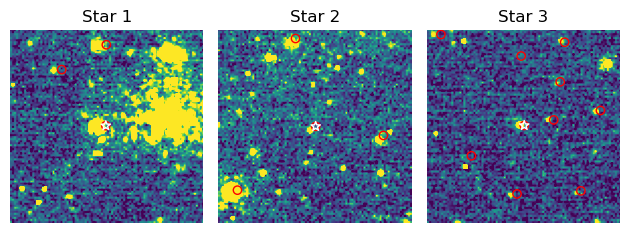

2024-01-19 11:16:19,967 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -134.315532 from OBSGEO-[XYZ].
Set OBSGEO-B to    -3.213224 from OBSGEO-[XYZ].
Set OBSGEO-H to 1299094589.651 from OBSGEO-[XYZ]'.
  warnings.warn(



/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_08201_00004_nrcb4_align.fits 0.0 0.0


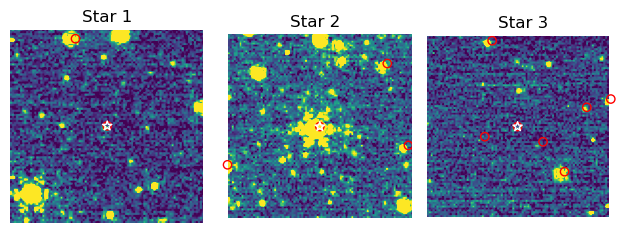

2024-01-19 11:16:23,338 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -120.025295 from OBSGEO-[XYZ].
Set OBSGEO-B to   -11.484850 from OBSGEO-[XYZ].
Set OBSGEO-H to 1386067713.035 from OBSGEO-[XYZ]'.
  warnings.warn(



/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002002_02201_00001_nrcb2_align.fits 0.0 0.0


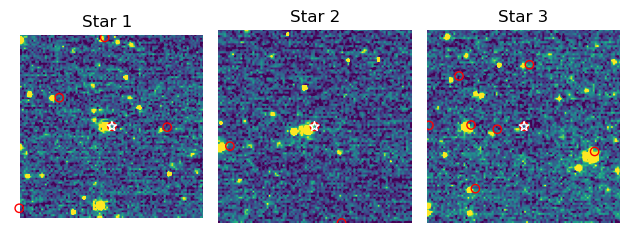

2024-01-19 11:16:26,580 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -120.020642 from OBSGEO-[XYZ].
Set OBSGEO-B to   -11.487662 from OBSGEO-[XYZ].
Set OBSGEO-H to 1386104450.505 from OBSGEO-[XYZ]'.
  warnings.warn(



/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002002_02201_00003_nrcb2_align.fits 0.0 0.0


2024-01-19 11:16:29,840 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -134.376742 from OBSGEO-[XYZ].
Set OBSGEO-B to    -3.179688 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298825238.212 from OBSGEO-[XYZ]'.
  warnings.warn(



/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_02201_00002_nrca3_align.fits 0.0 0.0


2024-01-19 11:16:32,874 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -134.323768 from OBSGEO-[XYZ].
Set OBSGEO-B to    -3.208710 from OBSGEO-[XYZ].
Set OBSGEO-H to 1299058303.688 from OBSGEO-[XYZ]'.
  warnings.warn(



/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_08201_00001_nrcb4_align.fits 0.0 0.0


2024-01-19 11:16:35,946 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -134.370854 from OBSGEO-[XYZ].
Set OBSGEO-B to    -3.182913 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298851117.169 from OBSGEO-[XYZ]'.
  warnings.warn(



/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_02201_00004_nrca3_align.fits 0.0 0.0


2024-01-19 11:16:39,002 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -134.380275 from OBSGEO-[XYZ].
Set OBSGEO-B to    -3.177752 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298809712.873 from OBSGEO-[XYZ]'.
  warnings.warn(



/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_02201_00001_nrca3_align.fits 0.0 0.0


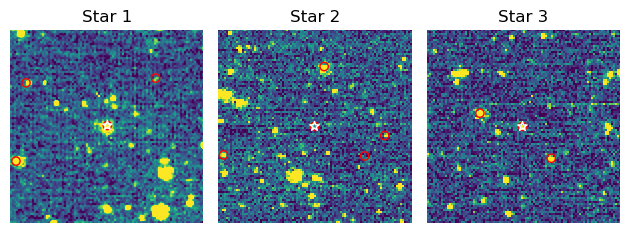

In [107]:
#fn = files[4]

for fn in files_overlap:

    im = ImageModel(fn)
    hdu = fits.open(fn)
    ww = WCS(hdu['SCI'].header)
    pixel_scale = np.sqrt(fits.getheader(fn, ext=1)['PIXAR_A2']*u.arcsec**2)/u.pix

    try: 
        reg = regions.RectangleSkyRegion(center=im.meta.wcs.pixel_to_world(hdu['SCI'].header['CRPIX1'], hdu['SCI'].header['CRPIX2']), 
                                         width=1900*u.pix*pixel_scale, height=1900*u.pix*pixel_scale)
        crds_in = crds[reg.contains(crds, wcs=ww)]

        position_1 = crds_in[np.random.randint(len(crds_in)-1)]
        position_2 = crds_in[np.random.randint(len(crds_in)-1)]
        position_3 = crds_in[np.random.randint(len(crds_in)-1)]

        size = (3*u.arcsec/pixel_scale, 3*u.arcsec/pixel_scale)

        cutout_1 = Cutout2D(hdu['SCI'].data, position=position_1, size=size, wcs=ww)
        cutout_2 = Cutout2D(hdu['SCI'].data, position=position_2, size=size, wcs=ww)
        cutout_3 = Cutout2D(hdu['SCI'].data, position=position_3, size=size, wcs=ww)

        ax_1 = plt.subplot(131, projection=cutout_1.wcs)
        ax_2 = plt.subplot(132, projection=cutout_2.wcs)
        ax_3 = plt.subplot(133, projection=cutout_3.wcs)

        vmin = 0 #np.nanpercentile(cutout_1.data.flatten(), minn)
        vmax = 50 #np.nanpercentile(cutout_1.data.flatten(), maxx)
        ax_1.imshow(np.nan_to_num(cutout_1.data), vmin=vmin, vmax=vmax)
        vmin = 0 #np.nanpercentile(cutout_2.data.flatten(), minn)
        vmax = 50 #np.nanpercentile(cutout_2.data.flatten(), maxx)
        ax_2.imshow(np.nan_to_num(cutout_2.data), vmin=vmin, vmax=vmax)
        vmin = 0 #np.nanpercentile(cutout_3.data.flatten(), minn)
        vmax = 50 #np.nanpercentile(cutout_3.data.flatten(), maxx)
        ax_3.imshow(np.nan_to_num(cutout_3.data), vmin=vmin, vmax=vmax)

        ra_shift = 0.0*u.arcsec  #
        dec_shift = 0.0*u.arcsec #

        reg = regions.RectangleSkyRegion(center=position_1, width=size[1]*pixel_scale, height=size[0]*pixel_scale)
        crds_1 = crds_in[reg.contains(crds_in, wcs=ww)]
        ax_1.scatter(crds_1.ra+ra_shift, crds_1.dec+dec_shift, edgecolor='r', facecolor='none', transform=ax_1.get_transform('world'))
        reg = regions.RectangleSkyRegion(center=position_2, width=size[1]*pixel_scale, height=size[0]*pixel_scale)
        crds_2 = crds_in[reg.contains(crds_in, wcs=ww)]
        ax_2.scatter(crds_2.ra+ra_shift, crds_2.dec+dec_shift, edgecolor='r', facecolor='none', transform=ax_2.get_transform('world'))
        reg = regions.RectangleSkyRegion(center=position_3, width=size[1]*pixel_scale, height=size[0]*pixel_scale)
        crds_3 = crds_in[reg.contains(crds_in, wcs=ww)]
        ax_3.scatter(crds_3.ra+ra_shift, crds_3.dec+dec_shift, edgecolor='r', facecolor='none', transform=ax_3.get_transform('world'))

        ax_1.scatter(position_1.ra, position_1.dec, edgecolor='white', facecolor='none', s=50, marker='*', transform=ax_1.get_transform('world'))
        ax_2.scatter(position_2.ra, position_2.dec, edgecolor='white', facecolor='none', s=50, marker='*', transform=ax_2.get_transform('world'))
        ax_3.scatter(position_3.ra, position_3.dec, edgecolor='white', facecolor='none', s=50, marker='*', transform=ax_3.get_transform('world'))

        ax_1.set_title("Star 1")
        ax_2.set_title("Star 2")
        ax_3.set_title("Star 3")

        ax_1.set_axis_off()
        ax_2.set_axis_off()
        ax_3.set_axis_off()

        print(fn, dec_shift.value, ra_shift.value)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(fn)
        print(e)


# Single Star Align

In [108]:
#position = SkyCoord('17:46:25.005', '-28:35:56.06', unit=(u.hourangle, u.deg))#; Image: (1600, 7190)
position = SkyCoord('17:46:24.482', '-28:36:24.07', unit=(u.hourangle, u.deg))#; Image: (1824, 6279); Value:  3.39456e+2
#position = SkyCoord('17:46:18.852', '-28:34:13.80', unit=(u.hourangle, u.deg))#; Image: (4235, 10516); Value:  8.56424e+1

#SkyCoord('17:46:19.057', '-28:34:13.48', unit=(u.hourangle, u.deg))#; Image: (4147, 10526); Value:  9.01411
#SkyCoord('17:46:18.832', '-28:34:12.36', unit=(u.hourangle, u.deg))#; Image: (4244, 10562); Value:  2.28679e+3

In [109]:
files_overlap

['/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_02201_00003_nrca3_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_08201_00003_nrcb4_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002002_02201_00004_nrcb2_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_08201_00002_nrcb4_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002002_02201_00002_nrcb2_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_08201_00004_nrcb4_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002002_02201_00001_nrcb2_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002002_02201_00003_nrcb2_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_02201_00002_nrca3_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_08201_00001_nrcb4_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F187N/pipeline/

2024-01-19 11:18:12,887 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -120.023434 from OBSGEO-[XYZ].
Set OBSGEO-B to   -11.485975 from OBSGEO-[XYZ].
Set OBSGEO-H to 1386082407.725 from OBSGEO-[XYZ]'.
  warnings.warn(



jw02221002002_02201_00002_nrcb2_align.fits 0.06 0.04
266.6020194444444 -28.606669444444446
(array(52.76556463), array(577.58591252))


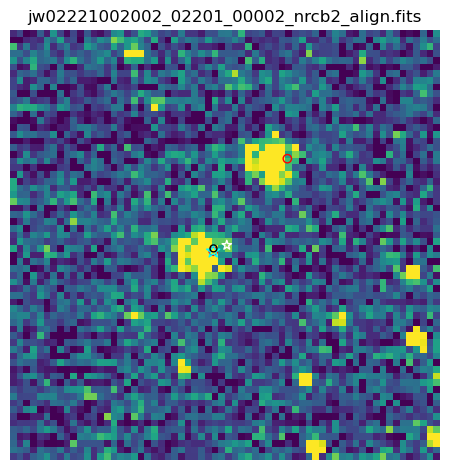

In [113]:
fn = files_overlap[4]

im = ImageModel(fn)
hdu = fits.open(fn)
ww = WCS(hdu['SCI'].header)
pixel_scale = np.sqrt(fits.getheader(fn, ext=1)['PIXAR_A2']*u.arcsec**2)/u.pix

reg = regions.RectangleSkyRegion(center=im.meta.wcs.pixel_to_world(hdu['SCI'].header['CRPIX1'], hdu['SCI'].header['CRPIX2']), 
                                 width=2048*u.pix*pixel_scale, height=2048*u.pix*pixel_scale)
crds_in = crds[reg.contains(crds, wcs=ww)]

size = (2*u.arcsec/pixel_scale, 2*u.arcsec/pixel_scale)

position_1 = position

cutout_1 = Cutout2D(hdu['SCI'].data, position=position_1, size=size, wcs=ww)

ax_1 = plt.subplot(111, projection=cutout_1.wcs)

vmin = 0 #np.nanpercentile(cutout_1.data.flatten(), minn)
vmax = 50 #np.nanpercentile(cutout_1.data.flatten(), maxx)
ax_1.imshow(np.nan_to_num(cutout_1.data), vmin=vmin, vmax=vmax)

ra_shift =  0.04*u.arcsec
dec_shift = 0.06*u.arcsec

reg = regions.RectangleSkyRegion(center=position_1, width=size[1]*pixel_scale, height=size[0]*pixel_scale)
crds_1 = crds_in[reg.contains(crds_in, wcs=ww)]
ax_1.scatter(crds_1.ra+ra_shift, crds_1.dec+dec_shift, edgecolor='r', facecolor='none', transform=ax_1.get_transform('world'))

ax_1.scatter(position_1.ra, position_1.dec, edgecolor='white', facecolor='none', s=50, marker='*', transform=ax_1.get_transform('world'))
ax_1.scatter(position_1.ra+ra_shift, position_1.dec+dec_shift, edgecolor='cyan', facecolor='none', s=100, marker='*', transform=ax_1.get_transform('world'))
px = SkyCoord(position_1.ra+ra_shift, position_1.dec+dec_shift).to_pixel(wcs=ww)
ax_1.scatter(SkyCoord.from_pixel(round(float(px[0])), round(float(px[1])), wcs=ww).ra, SkyCoord.from_pixel(px[0], px[1], wcs=ww).dec, edgecolor='k', facecolor='none', s=100, marker='.', transform=ax_1.get_transform('world'))

ax_1.set_title(os.path.basename(fn))

ax_1.set_axis_off()

print(os.path.basename(fn), dec_shift.value, ra_shift.value)
print((position_1.ra+ra_shift).value, (position_1.dec+dec_shift).value)
print(SkyCoord(position_1.ra+ra_shift, position_1.dec+dec_shift).to_pixel(wcs=ww))
plt.tight_layout()
plt.show()

# Compare with Tweakreg

In [130]:
files

['/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_02201_00002_nrcb2_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_02201_00002_nrca4_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002002_08201_00002_nrca2_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_02201_00002_nrcb3_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002002_08201_00004_nrca3_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002002_02201_00001_nrca4_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002002_08201_00004_nrcb2_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_08201_00002_nrcb3_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002002_08201_00004_nrca4_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_02201_00004_nrca1_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F187N/pipeline/

In [15]:
files_overlap

['/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_02201_00003_nrca3_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_08201_00003_nrcb4_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002002_02201_00004_nrcb2_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_08201_00002_nrcb4_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002002_02201_00002_nrcb2_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_08201_00004_nrcb4_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002002_02201_00001_nrcb2_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002002_02201_00003_nrcb2_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_02201_00002_nrca3_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_08201_00001_nrcb4_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F187N/pipeline/

In [7]:
fn = files_overlap[1]
#'/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002002_02201_00001_nrcb4_align.fits'#files_overlap[-1]#files[6]
fn_t = fn.replace('.fits', '_tweakregstep.fits')

ima = ImageModel(fn)
imb = ImageModel(fn_t)

hdu_a = fits.open(fn)#ImageModel(filename)
ww_a = WCS(hdu_a['SCI'].header)

hdu_b = fits.open(fn_t)#ImageModel(filename)
ww_b = WCS(hdu_b['SCI'].header)

reg_frame = regions.RectangleSkyRegion(center=ima.meta.wcs.pixel_to_world(hdu_a['SCI'].header['CRPIX1'], hdu_a['SCI'].header['CRPIX2']), width=2048*u.pix*pixel_scale, height=2048*u.pix*pixel_scale)
crds_frame = crds[reg_frame.contains(crds, wcs=ww_a)]

reg_b = regions.RectangleSkyRegion(center=imb.meta.wcs.pixel_to_world(hdu_b['SCI'].header['CRPIX1'], hdu_b['SCI'].header['CRPIX2']), width=2048*u.pix*pixel_scale, height=2048*u.pix*pixel_scale)
crds_ab = crds_frame[reg_b.contains(crds_frame, wcs=ww_b)]

NameError: name 'files_overlap' is not defined

In [33]:
position = crds_ab[np.random.randint(len(crds_ab)-1)]
position

<SkyCoord (ICRS): (ra, dec) in deg
    (266.59952954, -28.61492181)>

/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002002_02201_00004_nrcb2_align.fits


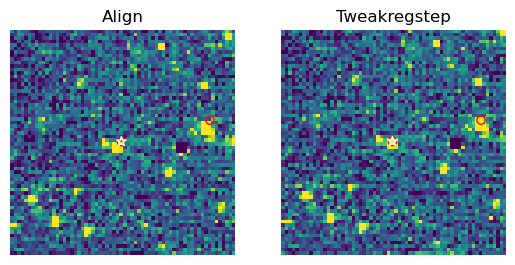

In [34]:
size = (2*u.arcsec/pixel_scale, 2*u.arcsec/pixel_scale)#im.meta.wcs.world_to_pixel(1*u.arcsec, 1*u.arcsec)

hdu_1 = fits.open(fn)
hdu_2 = fits.open(fn_t)

ww_1 = WCS(hdu_1['SCI'].header)
ww_2 = WCS(hdu_2['SCI'].header)

minn = 5
maxx = 90

cutout_1 = Cutout2D(hdu_1['SCI'].data, position=position, size=size, wcs=ww_1)
cutout_2 = Cutout2D(hdu_2['SCI'].data, position=position, size=size, wcs=ww_2)

ax_1 = plt.subplot(121, projection=cutout_1.wcs)
ax_2 = plt.subplot(122, projection=cutout_2.wcs)

vmin = 0#np.nanpercentile(cutout_1.data.flatten(), minn)
vmax = 50#np.nanpercentile(cutout_1.data.flatten(), maxx)
ax_1.imshow(np.nan_to_num(cutout_1.data), vmin=vmin, vmax=vmax)
vmin = 0#np.nanpercentile(cutout_2.data.flatten(), minn)
vmax = 50#np.nanpercentile(cutout_2.data.flatten(), maxx)
ax_2.imshow(np.nan_to_num(cutout_2.data), vmin=vmin, vmax=vmax)

reg = regions.RectangleSkyRegion(center=position, width=size[1]*pixel_scale, height=size[0]*pixel_scale)
crds_in = crds_ab[reg.contains(crds_ab, wcs=ww_1)]


ra_shift_1 =  0.0*u.arcsec#0.15*u.arcsec#-0.25*u.arcsec
dec_shift_1 = 0.0*u.arcsec#0.15*u.arcsec#0.05*u.arcsec
 
ra_shift_2 =  0.0*u.arcsec#0.0*u.arcsec
dec_shift_2 = 0.0*u.arcsec#0.05*u.arcsec#-0.05*u.arcsec

ax_1.scatter(crds_in.ra+ra_shift_1, crds_in.dec+dec_shift_1, edgecolor='r', facecolor='none', transform=ax_1.get_transform('world'))
ax_2.scatter(crds_in.ra+ra_shift_2, crds_in.dec+dec_shift_2, edgecolor='r', facecolor='none', transform=ax_2.get_transform('world'))

ax_1.scatter(position.ra, position.dec, edgecolor='white', facecolor='none', s=50, marker='*', transform=ax_1.get_transform('world'))
ax_2.scatter(position.ra, position.dec, edgecolor='white', facecolor='none', s=50, marker='*', transform=ax_2.get_transform('world'))

ax_1.set_title('Align')
ax_2.set_title('Tweakregstep')

ax_1.set_axis_off()
ax_2.set_axis_off()

print(fn)


# Checking Frames Alignment

In [52]:
frames = glob(f'{basepath}/{filtername}/pipeline/*_00001_*_cal.fits')
frames

['/orange/adamginsburg/jwst/cloudc//F182M/pipeline/jw02221002001_06201_00001_nrca4_cal.fits',
 '/orange/adamginsburg/jwst/cloudc//F182M/pipeline/jw02221002002_06201_00001_nrca1_cal.fits',
 '/orange/adamginsburg/jwst/cloudc//F182M/pipeline/jw02221002001_12201_00001_nrcb1_cal.fits',
 '/orange/adamginsburg/jwst/cloudc//F182M/pipeline/jw02221002002_06201_00001_nrcb4_cal.fits',
 '/orange/adamginsburg/jwst/cloudc//F182M/pipeline/jw02221002001_06201_00001_nrca3_cal.fits',
 '/orange/adamginsburg/jwst/cloudc//F182M/pipeline/jw02221002002_06201_00001_nrcb3_cal.fits',
 '/orange/adamginsburg/jwst/cloudc//F182M/pipeline/jw02221002001_12201_00001_nrca2_cal.fits',
 '/orange/adamginsburg/jwst/cloudc//F182M/pipeline/jw02221002002_06201_00001_nrca4_cal.fits',
 '/orange/adamginsburg/jwst/cloudc//F182M/pipeline/jw02221002001_06201_00001_nrca2_cal.fits',
 '/orange/adamginsburg/jwst/cloudc//F182M/pipeline/jw02221002001_06201_00001_nrca1_cal.fits',
 '/orange/adamginsburg/jwst/cloudc//F182M/pipeline/jw0222100

In [53]:
fn = frames[3]
fn

'/orange/adamginsburg/jwst/cloudc//F182M/pipeline/jw02221002002_06201_00001_nrcb4_cal.fits'

In [54]:
im = ImageModel(fn)
hdu = fits.open(fn)
ww = WCS(hdu['SCI'].header)
reg = regions.RectangleSkyRegion(center=im.meta.wcs.pixel_to_world(hdu['SCI'].header['CRPIX1'], hdu['SCI'].header['CRPIX2']), 
                                 width=2048*u.pix*pixel_scale, height=2048*u.pix*pixel_scale)
crds_in = crds[reg.contains(crds, wcs=ww)]

In [55]:
position = crds_in[np.random.randint(len(crds_in)-1)]

/orange/adamginsburg/jwst/cloudc//F182M/pipeline/jw02221002002_06201_00001_nrcb4_cal.fits
/orange/adamginsburg/jwst/cloudc//F182M/pipeline/jw02221002002_06201_00002_nrcb4_cal.fits
/orange/adamginsburg/jwst/cloudc//F182M/pipeline/jw02221002002_06201_00003_nrcb4_cal.fits
/orange/adamginsburg/jwst/cloudc//F182M/pipeline/jw02221002002_06201_00004_nrcb4_cal.fits


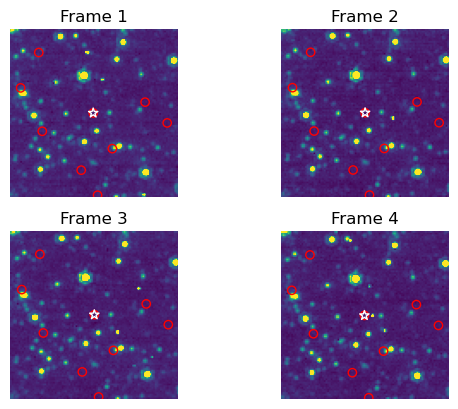

In [56]:
size = (3*u.arcsec/pixel_scale, 3*u.arcsec/pixel_scale)#im.meta.wcs.world_to_pixel(1*u.arcsec, 1*u.arcsec)
for n in range(4):
    fr = fn.replace('00001', f'0000{n+1}')#(fn[:-18]+str(n+1)+fn[-17:])#.replace('.fits', '_tweakregstep.fits')
    print(fr)
    im = ImageModel(fr)
    hdu = fits.open(fr)
    ww = WCS(hdu['SCI'].header)
    
    cutout = Cutout2D(hdu['SCI'].data, position=position, size=size, wcs=ww)
    
    reg = regions.RectangleSkyRegion(center=position, width=size[1]*pixel_scale, height=size[0]*pixel_scale)
    crds_cut = crds_in[reg.contains(crds_in, wcs=cutout.wcs)]
    
    ra_shift = 0.0*u.arcsec
    dec_shift = 0.0*u.arcsec
    
    ax = plt.subplot(2, 2, n+1, projection=cutout.wcs)
    ax.imshow(np.nan_to_num(cutout.data), vmin=0, vmax=50)
    ax.scatter(crds_cut.ra+ra_shift, crds_cut.dec+dec_shift, edgecolor='r', facecolor='none', transform=ax.get_transform('world'))
    ax.scatter(position.ra, position.dec, edgecolor='white', facecolor='none', s=50, marker='*', transform=ax.get_transform('world'))
    ax.set_title(f'Frame {n+1}')
    ax.set_axis_off()


In [59]:
ls /orange/adamginsburg/jwst/brick//F182M/pipeline/*_*_0000*_nrcb1_cal.fits

/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00001_nrcb1_cal.fits
/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00002_nrcb1_cal.fits
/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00003_nrcb1_cal.fits
/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00004_nrcb1_cal.fits
/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00005_nrcb1_cal.fits
/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00006_nrcb1_cal.fits
/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00007_nrcb1_cal.fits
/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00008_nrcb1_cal.fits
/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00009_nrcb1_cal.fits


In [ ]:
frames = glob(f'{basepath}/{filtername}/pipeline/*_*_*_00006_*_align.fits')

In [ ]:
fn = frames[0]
im = ImageModel(fn)
hdu = fits.open(fn)
ww = WCS(hdu['SCI'].header)
reg = regions.RectangleSkyRegion(center=im.meta.wcs.pixel_to_world(hdu['SCI'].header['CRPIX1'], hdu['SCI'].header['CRPIX2']), 
                                 width=2048*u.pix*pixel_scale, height=2048*u.pix*pixel_scale)
crds_in = crds[reg.contains(crds, wcs=ww)]

IndexError: list index out of range

In [ ]:
position = crds_in[np.random.randint(len(crds_in)-1)]

In [ ]:
plt.figure(figsize=(12,12))
size = (2*u.arcsec/pixel_scale, 2*u.arcsec/pixel_scale)#im.meta.wcs.world_to_pixel(1*u.arcsec, 1*u.arcsec)
for n in range(4):
    fr = fn.replace('00006', f'0000{n+1}')#(fn[:-18]+str(n+1)+fn[-17:])#.replace('.fits', '_tweakregstep.fits')
    print(fr)
    im = ImageModel(fr)
    hdu = fits.open(fr)
    ww = WCS(hdu['SCI'].header)
    
    cutout = Cutout2D(hdu['SCI'].data, position=position, size=size, wcs=ww)
    
    reg = regions.RectangleSkyRegion(center=position, width=size[1]*pixel_scale, height=size[0]*pixel_scale)
    crds_cut = crds_in[reg.contains(crds_in, wcs=cutout.wcs)]
    
    ra_shift = 0.0*u.arcsec
    dec_shift = 0.0*u.arcsec
    
    ax = plt.subplot(2, 2, n+1, projection=cutout.wcs)
    ax.imshow(np.nan_to_num(cutout.data), vmin=0, vmax=50)
    ax.scatter(crds_cut.ra+ra_shift, crds_cut.dec+dec_shift, edgecolor='r', facecolor='none', transform=ax.get_transform('world'))
    ax.scatter(position.ra, position.dec, edgecolor='white', facecolor='none', s=50, marker='*', transform=ax.get_transform('world'))
    ax.set_title(f'Frame {n+1}')
    ax.set_axis_off()


/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00001_nrca1_cal.fits
/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00002_nrca1_cal.fits
/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00003_nrca1_cal.fits
/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00004_nrca1_cal.fits


In [ ]:
plt.figure(figsize=(12,12))
size = (2*u.arcsec/pixel_scale, 2*u.arcsec/pixel_scale)#im.meta.wcs.world_to_pixel(1*u.arcsec, 1*u.arcsec)
for n in range(3):
    fr = fn.replace('00006', f'0000{n+6}')#(fn[:-18]+str(n+1)+fn[-17:])#.replace('.fits', '_tweakregstep.fits')
    print(fr)
    im = ImageModel(fr)
    hdu = fits.open(fr)
    ww = WCS(hdu['SCI'].header)
    
    cutout = Cutout2D(hdu['SCI'].data, position=position, size=size, wcs=ww)
    
    reg = regions.RectangleSkyRegion(center=position, width=size[1]*pixel_scale, height=size[0]*pixel_scale)
    crds_cut = crds_in[reg.contains(crds_in, wcs=cutout.wcs)]
    
    ra_shift = 0.0*u.arcsec
    dec_shift = 0.0*u.arcsec
    
    ax = plt.subplot(2, 2, n+1, projection=cutout.wcs)
    ax.imshow(np.nan_to_num(cutout.data), vmin=0, vmax=50)
    ax.scatter(crds_cut.ra+ra_shift, crds_cut.dec+dec_shift, edgecolor='r', facecolor='none', transform=ax.get_transform('world'))
    ax.scatter(position.ra, position.dec, edgecolor='white', facecolor='none', s=50, marker='*', transform=ax.get_transform('world'))
    ax.set_title(f'Frame {n+6}')
    ax.set_axis_off()


/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00006_nrca1_cal.fits
/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00007_nrca1_cal.fits
/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00008_nrca1_cal.fits


# Big Test

In [525]:
files = glob('/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw0222100200*_*_00001_nrc[a,b]4_align.fits')
len(files)

8

In [532]:
plt.figure(figsize=(12,6))
size = (2*u.arcsec/pixel_scale, 2*u.arcsec/pixel_scale)#im.meta.wcs.world_to_pixel(1*u.arcsec, 1*u.arcsec)
n = 0
for fn in files:
    fr = fn#(fn[:-12]+str(n+1)+fn[-11:])#.replace('.fits', '_tweakregstep.fits')
    print(fr)
    im = ImageModel(fr)
    hdu = fits.open(fr)
    ww = WCS(hdu['SCI'].header)
    
    reg = regions.RectangleSkyRegion(center=im.meta.wcs.pixel_to_world(hdu['SCI'].header['CRPIX1'], hdu['SCI'].header['CRPIX2']), 
                                 width=1700*u.pix*pixel_scale, height=1700*u.pix*pixel_scale)
    crds_in = crds[reg.contains(crds, wcs=ww)]
    position = crds_in[np.random.randint(len(crds_in)-1)]
    
    cutout = Cutout2D(hdu['SCI'].data, position=position, size=size, wcs=ww)
    
    reg = regions.RectangleSkyRegion(center=position, width=size[1]*pixel_scale, height=size[0]*pixel_scale)
    crds_cut = crds_in[reg.contains(crds_in, wcs=cutout.wcs)]
    
    if 'nrca' in fr:
        ra_shift = 0.23*u.arcsec
        dec_shift = -0.1*u.arcsec
    else: 
        ra_shift = 0.0*u.arcsec
        dec_shift = 0.0*u.arcsec
    
    ax = plt.subplot(2, 4, n+1, projection=cutout.wcs)
    ax.imshow(np.nan_to_num(cutout.data), vmin=0, vmax=50)
    ax.scatter(crds_cut.ra+ra_shift, crds_cut.dec+dec_shift, edgecolor='r', facecolor='none', transform=ax.get_transform('world'))
    ax.scatter(position.ra, position.dec, edgecolor='white', facecolor='none', s=50, marker='*', transform=ax.get_transform('world'))
    ax.set_title(os.path.basename(fr), fontsize=8)
    ax.set_axis_off()
    n+=1
plt.tight_layout()

/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002002_02201_00001_nrca4_align.fits
/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_08201_00001_nrca4_align.fits
/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002002_02201_00001_nrcb4_align.fits
/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002002_08201_00001_nrcb4_align.fits
/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_08201_00001_nrcb4_align.fits
/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_02201_00001_nrcb4_align.fits
/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002001_02201_00001_nrca4_align.fits
/orange/adamginsburg/jwst/cloudc/F187N/pipeline/jw02221002002_08201_00001_nrca4_align.fits


# Compare A and B with same chips

In [82]:
chips = glob(f'{basepath}/{filtername}/pipeline/*_06201_00001_nrc[a]1_cal.fits')
chips

['/orange/adamginsburg/jwst/cloudc//F182M/pipeline/jw02221002002_06201_00001_nrca1_cal.fits',
 '/orange/adamginsburg/jwst/cloudc//F182M/pipeline/jw02221002001_06201_00001_nrca1_cal.fits']

In [83]:
plt.figure(figsize=(12,12))
size = (2*u.arcsec/pixel_scale, 2*u.arcsec/pixel_scale)#im.meta.wcs.world_to_pixel(1*u.arcsec, 1*u.arcsec)
n = 0
for fn in chips:
    fr = fn#fn.replace('00006', f'0000{n+6}')#(fn[:-18]+str(n+1)+fn[-17:])#.replace('.fits', '_tweakregstep.fits')
    print(fr)
    im = ImageModel(fr)
    hdu = fits.open(fr)
    ww = WCS(hdu['SCI'].header)
    reg = regions.RectangleSkyRegion(center=im.meta.wcs.pixel_to_world(hdu['SCI'].header['CRPIX1'], hdu['SCI'].header['CRPIX2']), 
                                 width=2048*u.pix*pixel_scale, height=2048*u.pix*pixel_scale)
    crds_in = crds[reg.contains(crds, wcs=ww)]
    
    position = crds_in[np.random.randint(len(crds_in)-1)]
    
    cutout = Cutout2D(hdu['SCI'].data, position=position, size=size, wcs=ww)
    
    reg = regions.RectangleSkyRegion(center=position, width=size[1]*pixel_scale, height=size[0]*pixel_scale)
    crds_cut = crds_in[reg.contains(crds_in, wcs=cutout.wcs)]
    
    ra_shift = 0.0*u.arcsec
    dec_shift = 0.0*u.arcsec
    
    ax = plt.subplot(1, 2, n+1, projection=cutout.wcs)
    ax.imshow(np.nan_to_num(cutout.data), vmin=0, vmax=50)
    ax.scatter(crds_cut.ra+ra_shift, crds_cut.dec+dec_shift, edgecolor='r', facecolor='none', transform=ax.get_transform('world'))
    ax.scatter(position.ra, position.dec, edgecolor='white', facecolor='none', s=50, marker='*', transform=ax.get_transform('world'))
    ax.set_title(f'Frame {n+1}')
    ax.set_axis_off()
    n += 1


/orange/adamginsburg/jwst/cloudc//F182M/pipeline/jw02221002002_06201_00001_nrca1_cal.fits


NoConvergence: 'WCS.all_world2pix' failed to converge to the requested accuracy.
After 20 iterations, the solution is diverging at least for one input point.

<Figure size 1200x1200 with 0 Axes>

# Checking Chips Alignment

In [183]:
chips = glob(f'{basepath}/{filtername}/pipeline/*_*_00002_nrc[a,b]1_align.fits')
chips

['/orange/adamginsburg/jwst/cloudc//F182M/pipeline/jw02221002001_06201_00002_nrcb1_align.fits',
 '/orange/adamginsburg/jwst/cloudc//F182M/pipeline/jw02221002002_12201_00002_nrca1_align.fits',
 '/orange/adamginsburg/jwst/cloudc//F182M/pipeline/jw02221002002_12201_00002_nrcb1_align.fits',
 '/orange/adamginsburg/jwst/cloudc//F182M/pipeline/jw02221002002_06201_00002_nrca1_align.fits',
 '/orange/adamginsburg/jwst/cloudc//F182M/pipeline/jw02221002001_06201_00002_nrca1_align.fits',
 '/orange/adamginsburg/jwst/cloudc//F182M/pipeline/jw02221002002_06201_00002_nrcb1_align.fits',
 '/orange/adamginsburg/jwst/cloudc//F182M/pipeline/jw02221002001_12201_00002_nrcb1_align.fits',
 '/orange/adamginsburg/jwst/cloudc//F182M/pipeline/jw02221002001_12201_00002_nrca1_align.fits']

In [184]:
ls -l /orange/adamginsburg/jwst/cloudc//F182M/pipeline/jw02221002002_06201_00002_nrca1_align.fits

-rw-rw-r--+ 1 savannahgramze adamginsburg 117541440 Feb 29 16:58 /orange/adamginsburg/jwst/cloudc//F182M/pipeline/jw02221002002_06201_00002_nrca1_align.fits


In [187]:
fn = chips[1]
fn

'/orange/adamginsburg/jwst/cloudc//F182M/pipeline/jw02221002002_12201_00002_nrca1_align.fits'

/orange/adamginsburg/jwst/cloudc//F182M/pipeline/jw02221002002_12201_00002_nrca1_align.fits
/orange/adamginsburg/jwst/cloudc//F182M/pipeline/jw02221002002_12201_00002_nrca2_align.fits
/orange/adamginsburg/jwst/cloudc//F182M/pipeline/jw02221002002_12201_00002_nrca3_align.fits
/orange/adamginsburg/jwst/cloudc//F182M/pipeline/jw02221002002_12201_00002_nrca4_align.fits


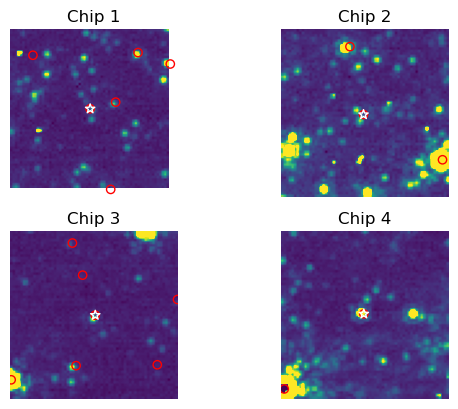

In [189]:
size = (2*u.arcsec/pixel_scale, 2*u.arcsec/pixel_scale)#im.meta.wcs.world_to_pixel(1*u.arcsec, 1*u.arcsec)
for n in range(4):
    fr = (fn.replace('1_align', f'{n+1}_align'))#.replace('.fits', '_tweakregstep.fits')
    print(fr)
    im = ImageModel(fr)
    hdu = fits.open(fr)
    ww = WCS(hdu['SCI'].header)
    
    reg = regions.RectangleSkyRegion(center=im.meta.wcs.pixel_to_world(hdu['SCI'].header['CRPIX1'], hdu['SCI'].header['CRPIX2']), 
                                 width=1700*u.pix*pixel_scale, height=1700*u.pix*pixel_scale)
    crds_in = crds[reg.contains(crds, wcs=ww)]
    position = crds_in[np.random.randint(len(crds_in)-1)]
    
    cutout = Cutout2D(hdu['SCI'].data, position=position, size=size, wcs=ww)
    
    reg = regions.RectangleSkyRegion(center=position, width=size[1]*pixel_scale, height=size[0]*pixel_scale)
    crds_cut = crds_in[reg.contains(crds_in, wcs=cutout.wcs)]
    
    if '_destreak' in fn:
        ra_shift = 0.0*u.arcsec
        dec_shift = 0.0 * u.arcsec
    if 'nrcb' in fn:
        ra_shift = 0.0*u.arcsec
        dec_shift = 0.0*u.arcsec#-0.05*u.arcsec
    elif 'nrca' in fn:
        ra_shift = 0.0*u.arcsec#-0.4*u.arcsec
        dec_shift = 0.0*u.arcsec#0.2*u.arcsec
    
    ax = plt.subplot(2, 2, n+1, projection=cutout.wcs)
    ax.imshow(np.nan_to_num(cutout.data), vmin=0, vmax=50)
    ax.scatter(crds_cut.ra-ra_shift, crds_cut.dec-dec_shift, edgecolor='r', facecolor='none', transform=ax.get_transform('world'))
    ax.scatter(position.ra, position.dec, edgecolor='white', facecolor='none', s=50, marker='*', transform=ax.get_transform('world'))
    ax.set_title(f'Chip {n+1}')
    ax.set_axis_off()

In [156]:
fn = chips[1]

/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00001_nrcb1_cal.fits
/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00001_nrcb2_cal.fits
/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00001_nrcb3_cal.fits
/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00001_nrcb4_cal.fits


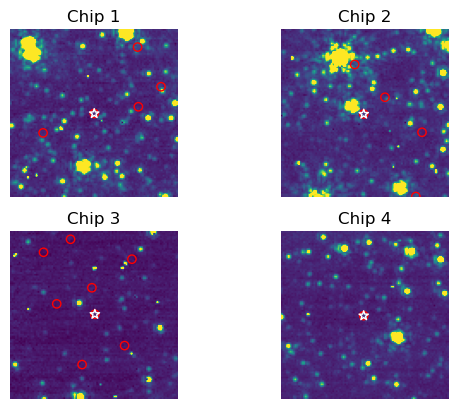

In [158]:
size = (3*u.arcsec/pixel_scale, 3*u.arcsec/pixel_scale)#im.meta.wcs.world_to_pixel(1*u.arcsec, 1*u.arcsec)
for n in range(4):
    fr = (fn.replace('1_cal', f'{n+1}_cal'))#.replace('.fits', '_tweakregstep.fits')
    print(fr)
    im = ImageModel(fr)
    hdu = fits.open(fr)
    ww = WCS(hdu['SCI'].header)
    
    reg = regions.RectangleSkyRegion(center=im.meta.wcs.pixel_to_world(hdu['SCI'].header['CRPIX1'], hdu['SCI'].header['CRPIX2']), 
                                 width=1700*u.pix*pixel_scale, height=1700*u.pix*pixel_scale)
    crds_in = crds[reg.contains(crds, wcs=ww)]
    position = crds_in[np.random.randint(len(crds_in)-1)]
    
    cutout = Cutout2D(hdu['SCI'].data, position=position, size=size, wcs=ww)
    
    reg = regions.RectangleSkyRegion(center=position, width=size[1]*pixel_scale, height=size[0]*pixel_scale)
    crds_cut = crds_in[reg.contains(crds_in, wcs=cutout.wcs)]
    
    if '_cal' in fn:
        ra_shift = 0.0*u.arcsec
        dec_shift = 0.0 * u.arcsec
    #elif 'nrcb' in fn:
    #    ra_shift = 0.18*u.arcsec
    #    dec_shift =-0.25*u.arcsec
    #elif 'nrca' in fn:
    #    ra_shift = -0.05*u.arcsec
    #    dec_shift = -0.11*u.arcsec
    
    ax = plt.subplot(2, 2, n+1, projection=cutout.wcs)
    ax.imshow(np.nan_to_num(cutout.data), vmin=0, vmax=50)
    ax.scatter(crds_cut.ra+ra_shift, crds_cut.dec+dec_shift, edgecolor='r', facecolor='none', transform=ax.get_transform('world'))
    ax.scatter(position.ra, position.dec, edgecolor='white', facecolor='none', s=50, marker='*', transform=ax.get_transform('world'))
    ax.set_title(f'Chip {n+1}')
    ax.set_axis_off()

# Same Chip Alignment

In [66]:
chips = glob(f'{basepath}/{filtername}/pipeline/*_*_0000*_nrcb4_cal.fits')
chips

['/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00009_nrcb4_cal.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00004_nrcb4_cal.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00007_nrcb4_cal.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00002_nrcb4_cal.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00006_nrcb4_cal.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00008_nrcb4_cal.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00003_nrcb4_cal.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00001_nrcb4_cal.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00005_nrcb4_cal.fits']

/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00009_nrcb4_cal.fits
/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00004_nrcb4_cal.fits
/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00007_nrcb4_cal.fits
/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00002_nrcb4_cal.fits
/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00006_nrcb4_cal.fits
/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00008_nrcb4_cal.fits
/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00003_nrcb4_cal.fits
/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00001_nrcb4_cal.fits
/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00005_nrcb4_cal.fits


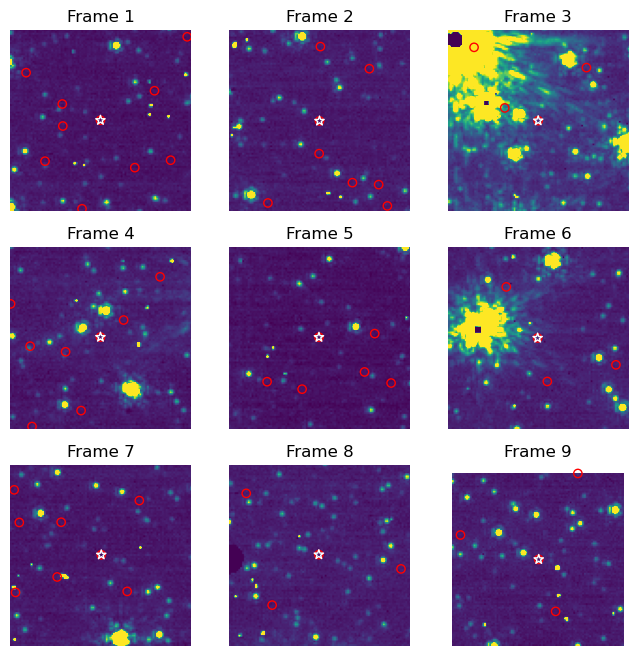

In [67]:
plt.figure(figsize=(8,8))
size = (3*u.arcsec/pixel_scale, 3*u.arcsec/pixel_scale)#im.meta.wcs.world_to_pixel(1*u.arcsec, 1*u.arcsec)
for n in range(9):
    fr = chips[n]#(fn.replace('1_cal', f'{n+1}_cal'))#.replace('.fits', '_tweakregstep.fits')
    print(fr)
    im = ImageModel(fr)
    hdu = fits.open(fr)
    ww = WCS(hdu['SCI'].header)
    
    reg = regions.RectangleSkyRegion(center=im.meta.wcs.pixel_to_world(hdu['SCI'].header['CRPIX1'], hdu['SCI'].header['CRPIX2']), 
                                 width=1700*u.pix*pixel_scale, height=1700*u.pix*pixel_scale)
    crds_in = crds[reg.contains(crds, wcs=ww)]
    position = crds_in[np.random.randint(len(crds_in)-1)]
    
    cutout = Cutout2D(hdu['SCI'].data, position=position, size=size, wcs=ww)
    
    reg = regions.RectangleSkyRegion(center=position, width=size[1]*pixel_scale, height=size[0]*pixel_scale)
    crds_cut = crds_in[reg.contains(crds_in, wcs=cutout.wcs)]
    
    ra_shift = 0.0*u.arcsec
    dec_shift = 0.0 * u.arcsec
    
    ax = plt.subplot(3, 3, n+1, projection=cutout.wcs)
    ax.imshow(np.nan_to_num(cutout.data), vmin=0, vmax=50)
    ax.scatter(crds_cut.ra+ra_shift, crds_cut.dec+dec_shift, edgecolor='r', facecolor='none', transform=ax.get_transform('world'))
    ax.scatter(position.ra, position.dec, edgecolor='white', facecolor='none', s=50, marker='*', transform=ax.get_transform('world'))
    ax.set_title(f'Frame {n+1}')
    ax.set_axis_off()

In [76]:
fn = chips[2]

im = ImageModel(fn)
hdu = fits.open(fn)
ww = WCS(hdu['SCI'].header)
pixel_scale = np.sqrt(fits.getheader(fn, ext=1)['PIXAR_A2']*u.arcsec**2)/u.pix

reg = regions.RectangleSkyRegion(center=im.meta.wcs.pixel_to_world(hdu['SCI'].header['CRPIX1'], hdu['SCI'].header['CRPIX2']), 
                                 width=2048*u.pix*pixel_scale, height=2048*u.pix*pixel_scale)
crds_in = crds[reg.contains(crds, wcs=ww)]

position_1 = crds_in[np.random.randint(len(crds_in)-1)]
position_2 = crds_in[np.random.randint(len(crds_in)-1)]
position_3 = crds_in[np.random.randint(len(crds_in)-1)]

size = (3*u.arcsec/pixel_scale, 3*u.arcsec/pixel_scale)

cutout_1 = Cutout2D(hdu['SCI'].data, position=position_1, size=size, wcs=ww)
cutout_2 = Cutout2D(hdu['SCI'].data, position=position_2, size=size, wcs=ww)
cutout_3 = Cutout2D(hdu['SCI'].data, position=position_3, size=size, wcs=ww)

ax_1 = plt.subplot(131, projection=cutout_1.wcs)
ax_2 = plt.subplot(132, projection=cutout_2.wcs)
ax_3 = plt.subplot(133, projection=cutout_3.wcs)

ax_1.imshow(np.nan_to_num(cutout_1.data), vmin=vmin, vmax=vmax)
ax_2.imshow(np.nan_to_num(cutout_2.data), vmin=vmin, vmax=vmax)
ax_3.imshow(np.nan_to_num(cutout_3.data), vmin=vmin, vmax=vmax)

ra_shift = 0.14*u.arcsec  #
dec_shift = -0.29*u.arcsec #

reg = regions.RectangleSkyRegion(center=position_1, width=size[1]*pixel_scale, height=size[0]*pixel_scale)
crds_1 = crds_in[reg.contains(crds_in, wcs=ww)]
ax_1.scatter(crds_1.ra+ra_shift, crds_1.dec+dec_shift, edgecolor='r', facecolor='none', transform=ax_1.get_transform('world'))
reg = regions.RectangleSkyRegion(center=position_2, width=size[1]*pixel_scale, height=size[0]*pixel_scale)
crds_2 = crds_in[reg.contains(crds_in, wcs=ww)]
ax_2.scatter(crds_2.ra+ra_shift, crds_2.dec+dec_shift, edgecolor='r', facecolor='none', transform=ax_2.get_transform('world'))
reg = regions.RectangleSkyRegion(center=position_3, width=size[1]*pixel_scale, height=size[0]*pixel_scale)
crds_3 = crds_in[reg.contains(crds_in, wcs=ww)]
ax_3.scatter(crds_3.ra+ra_shift, crds_3.dec+dec_shift, edgecolor='r', facecolor='none', transform=ax_3.get_transform('world'))

ax_1.scatter(position_1.ra, position_1.dec, edgecolor='white', facecolor='none', s=50, marker='*', transform=ax_1.get_transform('world'))
ax_2.scatter(position_2.ra, position_2.dec, edgecolor='white', facecolor='none', s=50, marker='*', transform=ax_2.get_transform('world'))
ax_3.scatter(position_3.ra, position_3.dec, edgecolor='white', facecolor='none', s=50, marker='*', transform=ax_3.get_transform('world'))

ax_1.set_title("Star 1")
ax_2.set_title("Star 2")
ax_3.set_title("Star 3")

ax_1.set_axis_off()
ax_2.set_axis_off()
ax_3.set_axis_off()

print(fn, dec_shift.value, ra_shift.value)
plt.tight_layout()
plt.show()

/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00007_nrcb4_cal.fits -0.29 0.14


# Quality Check

In [77]:
chips = glob(f'{basepath}/{filtername}/pipeline/*_*_00001_nrc*_cal.fits')
chips

['/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00001_nrca2_cal.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00001_nrca4_cal.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00001_nrca1_cal.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00001_nrcb2_cal.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00001_nrcb1_cal.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00001_nrcb4_cal.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00001_nrca3_cal.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00001_nrcb3_cal.fits']

/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00001_nrca2_cal.fits
/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00001_nrca4_cal.fits
/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00001_nrca1_cal.fits
/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00001_nrcb2_cal.fits
/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00001_nrcb1_cal.fits
/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00001_nrcb4_cal.fits
/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00001_nrca3_cal.fits
/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221001001_07101_00001_nrcb3_cal.fits


IndexError: list index out of range

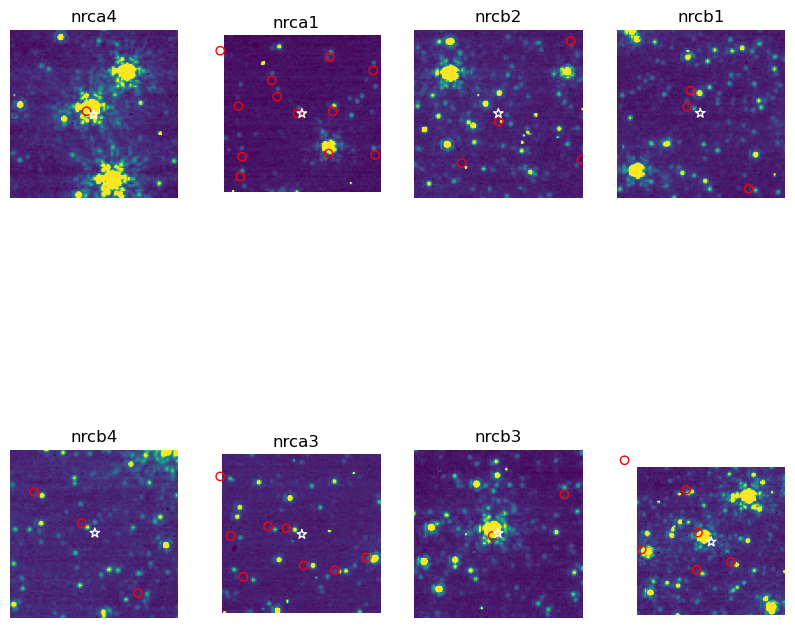

In [80]:
plt.figure(figsize=(10,10))
size = (3*u.arcsec/pixel_scale, 3*u.arcsec/pixel_scale)#im.meta.wcs.world_to_pixel(1*u.arcsec, 1*u.arcsec)
for n in range(8):
    fr = chips[n]#(fn.replace('1_cal', f'{n+1}_cal'))#.replace('.fits', '_tweakregstep.fits')
    print(fr)
    im = ImageModel(fr)
    hdu = fits.open(fr)
    ww = WCS(hdu['SCI'].header)
    
    reg = regions.RectangleSkyRegion(center=im.meta.wcs.pixel_to_world(hdu['SCI'].header['CRPIX1'], hdu['SCI'].header['CRPIX2']), 
                                 width=1700*u.pix*pixel_scale, height=1700*u.pix*pixel_scale)
    crds_in = crds[reg.contains(crds, wcs=ww)]
    position = crds_in[np.random.randint(len(crds_in)-1)]
    
    cutout = Cutout2D(hdu['SCI'].data, position=position, size=size, wcs=ww)
    
    reg = regions.RectangleSkyRegion(center=position, width=size[1]*pixel_scale, height=size[0]*pixel_scale)
    crds_cut = crds_in[reg.contains(crds_in, wcs=cutout.wcs)]
    
    ra_shift = 0.0*u.arcsec
    dec_shift = 0.0 * u.arcsec
    
    if 'brick' in fr:
        if 'nrca1' in fr:  
            dec_shift = 0.0 * u.arcsec
            ra_shift = -0.165 * u.arcsec
            ax.set_title('nrca1')
        elif 'nrca2' in fr: 
            dec_shift = -0.12 * u.arcsec
            ra_shift = 0.07 * u.arcsec
            ax.set_title('nrca2')
        elif 'nrca3' in fr: 
            dec_shift = -0.1 * u.arcsec
            ra_shift = -0.05 * u.arcsec
            ax.set_title('nrca3')
        elif 'nrca4' in fr: 
            dec_shift = -0.08 * u.arcsec
            ra_shift = 0.0 * u.arcsec
            ax.set_title('nrca4')
        elif 'nrcb1' in fr: 
            dec_shift = -0.23 * u.arcsec
            ra_shift = 0.2 * u.arcsec
            ax.set_title('nrcb1')
        elif 'nrcb2' in fr: 
            dec_shift = -0.23 * u.arcsec
            ra_shift = 0.13 * u.arcsec
            ax.set_title('nrcb2')
        elif 'nrcb3' in fr: 
            dec_shift = -0.26 * u.arcsec
            ra_shift = 0.22 * u.arcsec
            ax.set_title('nrcb3')
        elif 'nrcb4' in fr: 
            dec_shift = -0.29 * u.arcsec
            ra_shift = 0.14 * u.arcsec
            ax.set_title('nrcb4')
    
    ax = plt.subplot(2, 4, n+1, projection=cutout.wcs)
    ax.imshow(np.nan_to_num(cutout.data), vmin=0, vmax=50)
    ax.scatter(crds_cut.ra+ra_shift, crds_cut.dec+dec_shift, edgecolor='r', facecolor='none', transform=ax.get_transform('world'))
    ax.scatter(position.ra, position.dec, edgecolor='white', facecolor='none', s=50, marker='*', transform=ax.get_transform('world'))
    #ax.set_title(f'Chip {n+1}')
    ax.set_axis_off()

# Align All Frames

In [108]:
files = glob(f"/orange/adamginsburg/jwst/cloudc/{filtername}/pipeline/*nrc*[1-4]_cal.fits")
files

['/orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_12201_00004_nrca4_cal.fits',
 '/orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_06201_00003_nrcb1_cal.fits',
 '/orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_06201_00004_nrca3_cal.fits',
 '/orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00001_nrca4_cal.fits',
 '/orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_06201_00003_nrcb4_cal.fits',
 '/orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00004_nrca2_cal.fits',
 '/orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00004_nrca1_cal.fits',
 '/orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_12201_00004_nrcb1_cal.fits',
 '/orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00002_nrcb2_cal.fits',
 '/orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_06201_00001_nrca1_cal.fits',
 '/orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_06201_

<Quantity -0.05 arcsec>

In [182]:
for f in files:
    filename = f
    align_image = filename.replace("_cal.fits", "_align.fits")
    shutil.copy(filename, align_image)
    offsets_tbl = Table.read('/orange/adamginsburg/jwst/cloudc/offsets/Offsets_JWST_Cloud_C.csv')
    row = offsets_tbl[filename.split('/')[-1] == offsets_tbl['Filename_1']]
    print(f'Running manual align: {filename}')
    try:
        xshift = float(row['xshift (arcsec)'])*u.arcsec
        yshift = float(row['yshift (arcsec)'])*u.arcsec + 0.8*u.arcsec
    except:
        log.info('Something went wrong with manual align, running default values.')
        visit = filename.split('_')[0][-3:]
        if visit == '001':
            xshift = 7.95*u.arcsec # dec
            yshift = 0.6*u.arcsec # ra
        elif visit == '002':
            xshift = 3.85*u.arcsec
            yshift = 1.57*u.arcsec
        else:
            xshift = 0*u.arcsec
            yshift = 0*u.arcsec
    if filtername.upper() in ('F212N', 'F187N', 'F182M'):
        print('Short wavelength correction.')
        if 'nrca' in filename.lower():
            xshift += 0.0*u.arcsec # dec
            yshift += 0*u.arcsec # ra
        elif 'nrcb' in filename.lower():
            xshift += 0.0 * u.arcsec # 0.05
            yshift += 0.0 * u.arcsec
    align_fits = ImageModel(align_image)
    log.info(f'delta_ra: {yshift} delta_dec: {xshift}')
    ww = adjust_wcs(align_fits.meta.wcs, delta_ra = yshift, delta_dec = xshift)
    align_fits.meta.wcs = ww
    align_fits.save(align_image)
    align_fits = fits.open(align_image)
    align_fits[1].header.update(ww.to_fits()[0])
    align_fits.writeto(align_image, overwrite=True)
    #filename = align_image

2024-02-29 16:57:45,705 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_12201_00004_nrca4_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:57:45,914 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:57:47,041 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_06201_00003_nrcb1_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:57:47,266 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:57:48,142 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-02-29 16:57:48,318 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_06201_00004_nrca3_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:57:49,098 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00001_nrca4_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:57:49,313 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:57:50,392 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_06201_00003_nrcb4_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:57:50,595 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:57:51,282 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00004_nrca2_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:57:51,522 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:57:52,435 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00004_nrca1_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:57:52,933 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:57:54,382 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-02-29 16:57:54,560 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_12201_00004_nrcb1_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:57:55,955 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-02-29 16:57:56,139 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00002_nrcb2_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:57:57,342 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_06201_00001_nrca1_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:57:57,541 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec
2024-02-29 16:57:58,351 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_06201_00003_nrca3_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:57:58,552 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:57:59,817 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00003_nrcb1_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:58:00,046 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:58:01,221 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_12201_00004_nrcb4_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:58:01,430 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:58:02,631 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00003_nrca1_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:58:02,854 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:58:04,044 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_12201_00004_nrca1_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:58:04,486 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:58:05,509 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_12201_00002_nrcb2_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:58:05,731 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:58:06,945 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_12201_00001_nrcb1_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:58:07,155 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:58:08,214 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00003_nrcb3_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:58:08,435 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:58:09,434 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_06201_00001_nrcb4_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:58:09,693 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:58:10,808 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-02-29 16:58:10,997 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_12201_00002_nrcb2_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:58:11,893 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00002_nrcb4_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:58:12,129 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:58:13,819 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00001_nrca3_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:58:14,264 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:58:15,268 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00002_nrcb3_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:58:15,502 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:58:16,287 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_06201_00001_nrcb3_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:58:16,518 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:58:18,002 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_12201_00001_nrca2_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:58:18,243 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:58:19,278 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_12201_00002_nrca3_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:58:19,493 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:58:21,010 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_06201_00004_nrcb4_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:58:21,229 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:58:22,361 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00002_nrca2_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:58:22,556 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec
2024-02-29 16:58:24,151 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_06201_00004_nrcb1_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:58:24,359 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:58:25,371 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-02-29 16:58:25,551 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_06201_00001_nrca4_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:58:26,393 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-02-29 16:58:26,568 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_12201_00003_nrcb2_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:58:27,769 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_12201_00003_nrcb4_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:58:27,967 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec
2024-02-29 16:58:29,039 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_06201_00002_nrca4_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:58:29,259 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:58:30,127 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_12201_00003_nrcb2_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:58:30,324 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec
2024-02-29 16:58:31,237 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-02-29 16:58:31,427 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00001_nrca2_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:58:32,338 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_06201_00002_nrcb2_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:58:32,606 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:58:33,929 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_06201_00002_nrca2_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:58:34,146 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:58:35,004 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-02-29 16:58:35,194 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_06201_00003_nrcb3_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:58:36,242 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_06201_00004_nrca4_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:58:36,466 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:58:37,616 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-02-29 16:58:37,795 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_12201_00003_nrca2_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:58:38,586 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_06201_00002_nrca3_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:58:38,815 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:58:39,722 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00003_nrca3_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:58:39,942 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:58:40,885 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_12201_00002_nrca2_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:58:41,349 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:58:42,291 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-02-29 16:58:42,486 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_12201_00004_nrcb1_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:58:43,288 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_12201_00003_nrca4_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:58:43,505 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:58:44,707 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_12201_00003_nrcb3_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:58:44,929 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:58:46,948 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00001_nrca1_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:58:47,162 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:58:47,970 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_12201_00002_nrcb4_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:58:48,173 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:58:49,171 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_12201_00003_nrca2_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:58:49,390 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:58:50,221 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00003_nrca2_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:58:50,431 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:58:51,743 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_06201_00004_nrca1_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:58:51,955 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:58:53,124 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_12201_00001_nrcb3_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:58:53,347 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:58:54,274 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_12201_00003_nrca1_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:58:54,512 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:58:55,464 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00001_nrcb4_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:58:55,722 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:58:56,699 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_12201_00001_nrcb2_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:58:56,901 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:58:57,789 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_06201_00002_nrca1_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:58:58,013 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:58:59,119 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00003_nrca4_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:58:59,327 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:59:00,328 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_12201_00004_nrca2_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:00,539 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:59:01,436 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-02-29 16:59:01,630 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_06201_00001_nrcb2_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:59:02,488 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_12201_00003_nrca3_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:02,730 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:59:03,527 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-02-29 16:59:03,713 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_06201_00002_nrcb3_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:59:04,711 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_06201_00004_nrcb3_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:04,967 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:59:05,635 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00002_nrca3_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:06,167 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:59:07,221 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00004_nrcb2_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:07,441 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:59:08,394 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_12201_00002_nrca1_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:08,604 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:59:09,655 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00003_nrcb2_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:09,858 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:59:11,241 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00001_nrcb2_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:11,451 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:59:12,987 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_06201_00001_nrcb1_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:13,192 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:59:14,138 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_12201_00004_nrca3_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:14,340 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:59:15,482 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_12201_00001_nrca4_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:15,751 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:59:16,634 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_12201_00004_nrcb4_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:16,846 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:59:17,627 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00004_nrca3_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:17,870 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:59:19,589 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_06201_00004_nrcb2_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:19,795 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:59:20,656 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_12201_00004_nrca2_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:20,883 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:59:21,698 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_12201_00001_nrca1_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:21,905 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:59:22,766 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_06201_00002_nrcb4_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:23,296 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:59:24,428 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_12201_00002_nrcb1_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:59:24,623 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec
2024-02-29 16:59:25,528 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_12201_00001_nrca1_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:25,800 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:59:26,986 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_12201_00004_nrcb2_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:27,210 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:59:28,087 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_12201_00002_nrcb3_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:59:28,285 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec
2024-02-29 16:59:29,220 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-02-29 16:59:29,398 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_12201_00003_nrcb1_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:59:30,600 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_06201_00003_nrca1_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:59:30,798 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec
2024-02-29 16:59:31,899 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_06201_00001_nrca3_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:32,105 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:59:33,179 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00004_nrcb4_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:33,368 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:59:34,284 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_12201_00003_nrca3_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:34,504 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:59:36,508 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_12201_00001_nrcb1_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:36,747 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:59:38,004 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00002_nrcb1_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:38,253 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:59:39,549 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_06201_00003_nrcb2_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:39,764 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:59:40,857 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_12201_00003_nrca1_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:41,451 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:59:42,344 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_12201_00001_nrca4_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:42,550 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:59:43,525 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_12201_00001_nrcb4_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:43,757 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:59:44,509 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_12201_00002_nrca3_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:44,739 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:59:45,891 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_12201_00001_nrca2_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:46,135 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:59:46,968 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_06201_00002_nrcb1_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:47,188 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:59:48,359 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-02-29 16:59:48,554 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_12201_00004_nrca3_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:59:49,791 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00004_nrca4_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:49,995 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:59:51,087 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00003_nrcb4_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:51,351 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:59:52,838 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00001_nrcb1_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:53,101 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:59:54,150 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_06201_00001_nrca2_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:54,373 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 16:59:55,368 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_12201_00002_nrcb4_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:55,652 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:59:56,637 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_12201_00001_nrca3_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:56,899 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:59:58,085 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00001_nrcb3_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:58,301 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 16:59:59,623 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_12201_00004_nrca1_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 16:59:59,830 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 17:00:00,722 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_12201_00003_nrcb4_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 17:00:00,935 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 17:00:02,058 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00002_nrca4_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 17:00:02,287 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 17:00:03,152 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_12201_00001_nrcb3_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 17:00:03,468 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 17:00:04,507 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_12201_00001_nrcb2_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 17:00:04,756 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 17:00:05,814 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_06201_00003_nrca4_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 17:00:06,333 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 17:00:07,172 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_12201_00002_nrca4_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 17:00:07,376 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 17:00:08,301 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-02-29 17:00:08,489 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_12201_00003_nrcb1_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 17:00:09,666 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_12201_00002_nrcb1_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 17:00:09,870 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 17:00:10,813 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_12201_00002_nrcb3_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 17:00:11,053 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 17:00:11,952 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00004_nrcb3_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 17:00:12,201 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 17:00:13,555 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_12201_00004_nrcb3_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 17:00:13,798 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 17:00:14,847 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_12201_00003_nrca4_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 17:00:15,057 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 17:00:15,969 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_12201_00002_nrca1_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 17:00:16,199 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 17:00:17,272 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_12201_00004_nrcb3_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 17:00:17,512 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 17:00:18,446 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00002_nrca1_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 17:00:18,677 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 17:00:19,787 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_12201_00001_nrca3_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 17:00:20,013 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 17:00:21,015 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_12201_00003_nrcb3_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 17:00:21,637 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 17:00:22,654 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_12201_00004_nrcb2_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 17:00:22,875 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 17:00:23,980 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_12201_00001_nrcb4_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 17:00:24,184 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 17:00:25,019 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_12201_00004_nrca4_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 17:00:25,234 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 17:00:26,425 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_12201_00002_nrca4_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 17:00:26,673 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 17:00:27,526 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_12201_00002_nrca2_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 17:00:27,732 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-02-29 17:00:29,118 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_06201_00004_nrca2_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 17:00:29,328 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 17:00:30,914 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002002_06201_00003_nrca2_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.


2024-02-29 17:00:31,795 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-02-29 17:00:32,649 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-02-29 17:00:32,823 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align: /orange/adamginsburg/jwst/cloudc/F182M/pipeline/jw02221002001_06201_00004_nrcb1_cal.fits
INFO: Something went wrong with manual align, running default values. [unknown]
Short wavelength correction.
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


# Run Tweakreg

In [4]:
models = jwst.datamodels.open(glob(f"/orange/adamginsburg/jwst/cloudc/{filtername}/pipeline/*nrca*_align.fits"))
#jwst.datamodels.open(files)
#

In [5]:
abs_refcat = '/orange/adamginsburg/jwst/cloudc/catalogs/crowdsource_based_nircam-f405n_reference_astrometric_catalog_truncated10000.ecsv'


In [6]:
tweakreg = TweakRegStep()
tweakreg.fitgeometry = 'general'
tweakreg.kernel_fwhm = 2.341
tweakreg.brightest = 500
tweakreg.snr_threshold = 30
tweakreg.abs_refcat = abs_refcat
tweakreg.save_catalogs = True
tweakreg.catalog_format = 'ecsv'
#tweakreg.kernel_fwhm = fwhm_pix
tweakreg.nclip = 5
tweakreg.sharplo = 0.3
tweakreg.sharphi = 0.9
tweakreg.roundlo = -0.25
tweakreg.roundhi = 0.25
tweakreg.separation = 0.5
tweakreg.tolerance = 0.7
tweakreg.sigma = 3.0
tweakreg.output_dir = f"/orange/adamginsburg/jwst/cloudc/{filtername}/pipeline/"#output_dir
tweakreg.save_results = True
tweakreg.skip = False
tweakreg.searchrad = 0.5
tweakreg.abs_searchrad = 1.5

tweak = tweakreg.run(models)


2024-01-19 17:46:45,320 - stpipe.TweakRegStep - INFO - TweakRegStep instance created.
2024-01-19 17:46:45,576 - stpipe.TweakRegStep - INFO - Step TweakRegStep running with args (<ModelContainer>,).
2024-01-19 17:46:45,581 - stpipe.TweakRegStep - INFO - Step TweakRegStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/orange/adamginsburg/jwst/cloudc/F187N/pipeline/', 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': True, 'use_custom_catalogs': False, 'catalog_format': 'ecsv', 'catfile': '', 'kernel_fwhm': 2.341, 'snr_threshold': 30, 'sharplo': 0.3, 'sharphi': 0.9, 'roundlo': -0.25, 'roundhi': 0.25, 'brightest': 500, 'peakmax': None, 'bkg_boxsize': 400, 'enforce_user_order': False, 'expand_refcat': False, 'minobj': 15, 'searchrad': 0.5, 'use2dhist': True, 'separation': 0.5, 'tolerance': 0.7, 'xoffset': 0.0, '

In [ ]:
#fn = files[4]

for fn in files:
    fn = fn.replace('.fits', '_tweakregstep.fits')

    im = ImageModel(fn)
    hdu = fits.open(fn)
    ww = WCS(hdu['SCI'].header)
    pixel_scale = np.sqrt(fits.getheader(fn, ext=1)['PIXAR_A2']*u.arcsec**2)/u.pix

    try: 
        reg = regions.RectangleSkyRegion(center=im.meta.wcs.pixel_to_world(hdu['SCI'].header['CRPIX1'], hdu['SCI'].header['CRPIX2']), 
                                         width=1900*u.pix*pixel_scale, height=1900*u.pix*pixel_scale)
        crds_in = crds[reg.contains(crds, wcs=ww)]

        position_1 = crds_in[np.random.randint(len(crds_in)-1)]
        position_2 = crds_in[np.random.randint(len(crds_in)-1)]
        position_3 = crds_in[np.random.randint(len(crds_in)-1)]

        size = (3*u.arcsec/pixel_scale, 3*u.arcsec/pixel_scale)

        cutout_1 = Cutout2D(hdu['SCI'].data, position=position_1, size=size, wcs=ww)
        cutout_2 = Cutout2D(hdu['SCI'].data, position=position_2, size=size, wcs=ww)
        cutout_3 = Cutout2D(hdu['SCI'].data, position=position_3, size=size, wcs=ww)

        ax_1 = plt.subplot(131, projection=cutout_1.wcs)
        ax_2 = plt.subplot(132, projection=cutout_2.wcs)
        ax_3 = plt.subplot(133, projection=cutout_3.wcs)

        vmin = 0 #np.nanpercentile(cutout_1.data.flatten(), minn)
        vmax = 50 #np.nanpercentile(cutout_1.data.flatten(), maxx)
        ax_1.imshow(np.nan_to_num(cutout_1.data), vmin=vmin, vmax=vmax)
        vmin = 0 #np.nanpercentile(cutout_2.data.flatten(), minn)
        vmax = 50 #np.nanpercentile(cutout_2.data.flatten(), maxx)
        ax_2.imshow(np.nan_to_num(cutout_2.data), vmin=vmin, vmax=vmax)
        vmin = 0 #np.nanpercentile(cutout_3.data.flatten(), minn)
        vmax = 50 #np.nanpercentile(cutout_3.data.flatten(), maxx)
        ax_3.imshow(np.nan_to_num(cutout_3.data), vmin=vmin, vmax=vmax)

        ra_shift = 0.0*u.arcsec  #
        dec_shift = 0.0*u.arcsec #

        reg = regions.RectangleSkyRegion(center=position_1, width=size[1]*pixel_scale, height=size[0]*pixel_scale)
        crds_1 = crds_in[reg.contains(crds_in, wcs=ww)]
        ax_1.scatter(crds_1.ra+ra_shift, crds_1.dec+dec_shift, edgecolor='r', facecolor='none', transform=ax_1.get_transform('world'))
        reg = regions.RectangleSkyRegion(center=position_2, width=size[1]*pixel_scale, height=size[0]*pixel_scale)
        crds_2 = crds_in[reg.contains(crds_in, wcs=ww)]
        ax_2.scatter(crds_2.ra+ra_shift, crds_2.dec+dec_shift, edgecolor='r', facecolor='none', transform=ax_2.get_transform('world'))
        reg = regions.RectangleSkyRegion(center=position_3, width=size[1]*pixel_scale, height=size[0]*pixel_scale)
        crds_3 = crds_in[reg.contains(crds_in, wcs=ww)]
        ax_3.scatter(crds_3.ra+ra_shift, crds_3.dec+dec_shift, edgecolor='r', facecolor='none', transform=ax_3.get_transform('world'))

        ax_1.scatter(position_1.ra, position_1.dec, edgecolor='white', facecolor='none', s=50, marker='*', transform=ax_1.get_transform('world'))
        ax_2.scatter(position_2.ra, position_2.dec, edgecolor='white', facecolor='none', s=50, marker='*', transform=ax_2.get_transform('world'))
        ax_3.scatter(position_3.ra, position_3.dec, edgecolor='white', facecolor='none', s=50, marker='*', transform=ax_3.get_transform('world'))

        ax_1.set_title("Star 1")
        ax_2.set_title("Star 2")
        ax_3.set_title("Star 3")

        ax_1.set_axis_off()
        ax_2.set_axis_off()
        ax_3.set_axis_off()

        print(fn, dec_shift.value, ra_shift.value)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(fn)
        print(e)
